Notebook initialization:

You need to run the next 3 cells!

In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math

Esthetic definitions for the plots

In [2]:
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

Common settings for cosmological parameters and other CLASS parameters

In [3]:
common_settings = {
                   'output':'tCl,pCl,lCl',
                   # LambdaCDM parameters
                   'h':0.67556,
                   'omega_b':0.022032,
                   'omega_cdm':0.12038,
                   'A_s':2.215e-9,
                   'tau_reio':0.0925,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   'YHe':0.246,
                   'mass function' : 'T10',
                   'integrate_wrt_m200m' : 1
}

factor_sz = 1e-2

# testing cellls

In [4]:
M = Class()
M.set(common_settings)
M.set({
    'output': 'dndlnM',
     'mass function' : 'T10',
     'sz_verbose':10
})
M.compute()


In [5]:
z = 0.
m = 2e8
M.get_dndlnM_at_z_and_M(z,m)

7.292195626648195

In [6]:
M.struct_cleanup()
M.empty()

# Computing cluster abundance

In [ ]:
M = Class()
cluster_settings = {
                   # LambdaCDM parameters
                   'h':0.7,
                   'B': 1.,
                   'omega_b':0.022032,
                   'omega_cdm':0.12038,
                   #'A_s':2.215e-9,
                   'sigma8':0.8,
                   'tau_reio':0.0925,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   'YHe':0.246,
}

M.set(cluster_settings)
M.set({
    'output': 'dndlnM,SZ_counts',
    'mass function' : 'M500',
    'integrate_wrt_m500c': 1,
    'has_completeness_for_cc': 1,
    'experiment': 1, # 1:simons observatory, 0:planck
    'sz_verbose' : 10
})
M.compute()

In [20]:
dNdzdy_theoretical = M.dndzdy_theoretical()['dndzdy']
z_center = M.dndzdy_theoretical()['z_center']
z_edges = M.dndzdy_theoretical()['z_edges']
log10y_center = M.dndzdy_theoretical()['log10y_center']
log10y_edges = M.dndzdy_theoretical()['log10y_edges']
M.struct_cleanup()
M.empty()

In [21]:
N_z,N_y = np.shape(dNdzdy_theoretical)
N_clusters_z_theory = []
for iz in range(N_z):
    N_clusters_z_theory.append(np.sum(dNdzdy_theoretical[iz]))
N_clusters_y_theory = []
for iy in range(N_y):
    N_clusters_y_theory.append(np.sum(np.asarray(dNdzdy_theoretical)[:,iy]))



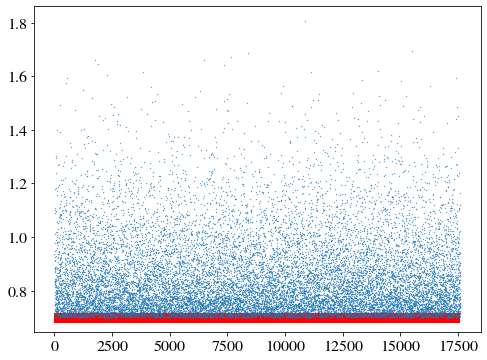

In [22]:
path_to_catalogue = '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_external_data_and_scripts/MFMF_SOSim_3freq_tiles/'
from astropy.io import fits
#"fits_image_filename = fits.util.get_testdata_filepath(path_to_catalogue+'MFMF_SOSim_3freq_tiles_M500.fits')
tcat = path_to_catalogue+'MFMF_SOSim_3freq_tiles_M500.fits'
list = fits.open(tcat)
data = list[1].data
z = data.field("redshift")
snr = data.field("SNR")
tile = data.field("tileName")
snrcut = 5
z = z[snr > snrcut]
snr = snr[snr > snrcut]
plt.plot(np.log10(snr),marker='o',ls='None',markersize=0.3)
plt.hlines(np.log10(snrcut),xmin=0,xmax=len(snr),color='r',lw=10)

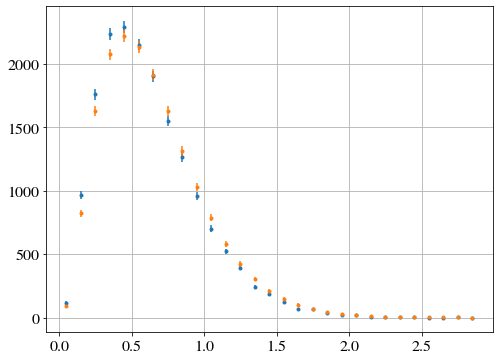

In [23]:
N_clusters_z, xedges = np.histogram(z, bins=z_edges)
plt.errorbar(z_center,N_clusters_z,yerr=np.sqrt(N_clusters_z),marker='o',markersize=3.,ls='none')
plt.errorbar(z_center,N_clusters_z_theory,yerr=np.sqrt(N_clusters_z_theory),marker='o',markersize=3.,ls='none')
plt.grid()

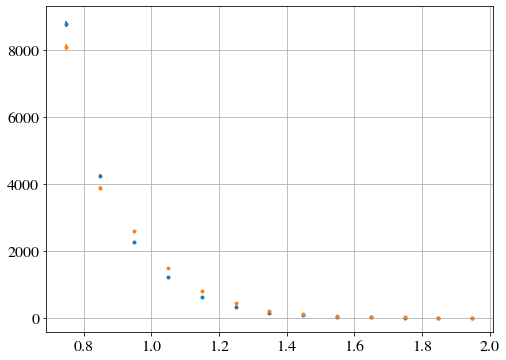

In [24]:
N_clusters_y, xedges = np.histogram(np.log10(snr), bins=log10y_edges)
plt.errorbar(log10y_center,N_clusters_y,yerr=np.sqrt(N_clusters_y),marker='o',markersize=3.,ls='none')
plt.errorbar(log10y_center,N_clusters_y_theory,yerr=np.sqrt(N_clusters_y_theory),marker='o',markersize=3.,ls='none')
plt.grid()

In [25]:
dNdzdy_catalog, zedges, yedges = np.histogram2d(z,np.log10(snr), bins=[z_edges,log10y_edges])
SZCC_Cash = 0.
for index_z in range(N_z):
    for index_y in range(N_y):
        if not dNdzdy_theoretical[index_z][index_y] == 0.:
            ln_factorial = 0.
            if not dNdzdy_catalog[index_z,index_y] == 0.:
                if dNdzdy_catalog[index_z,index_y] > 10.:
                    # Stirling approximation only for more than 10 elements
                    ln_factorial = 0.918939 + (dNdzdy_catalog[index_z,index_y] + 0.5) * np.log(dNdzdy_catalog[index_z,index_y]) - dNdzdy_catalog[index_z,index_y]
                else:
                    # Direct computation of factorial
                    ln_factorial = np.log(np.math.factorial(int(dNdzdy_catalog[index_z,index_y])))
            SZCC_Cash += (dNdzdy_catalog[index_z,index_y] * np.log(dNdzdy_theoretical[index_z][index_y]) - dNdzdy_theoretical[index_z][index_y] - ln_factorial)

# return ln(L)
loglkl = SZCC_Cash
print(loglkl)

-754.1791315727825


# Obtaining the power spectra

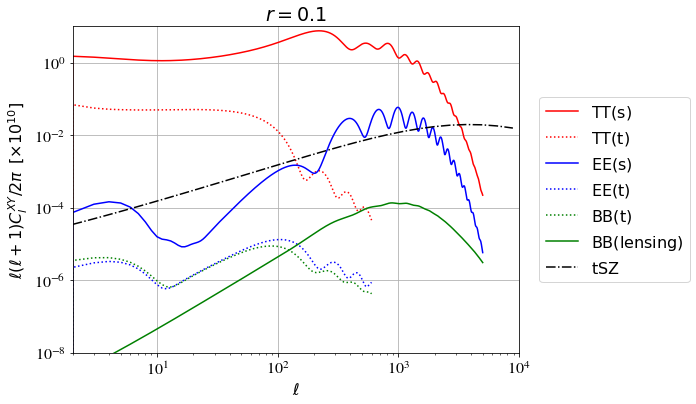

In [8]:


###############
#    
# call CLASS 
#
###############
#
# scalars only
#
M = Class()
M.set(common_settings)
M.set({'output':'tCl,pCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':5000})
M.compute()
cls = M.raw_cl(5000)
M.struct_cleanup()
M.empty()
#
# tensors only
#
M = Class()
M.set(common_settings)
l_max_tensors = 600
M.set({'output':'tCl,pCl','modes':'t','lensing':'no','r':0.1,'n_t':0,'l_max_tensors':l_max_tensors})
M.compute()
clt = M.raw_cl(l_max_tensors)
M.struct_cleanup()
M.empty()
#
# scalars + tensors (only in this case we can get the correct lensed ClBB)
#
M = Class()
M.set(common_settings)
M.set({'output':'tCl,pCl,lCl','modes':'s,t','lensing':'yes','r':0.1,'n_s':0.9619,'n_t':0,'l_max_scalars':5000,'l_max_tensors':l_max_tensors})
M.compute()
cl_tot = M.raw_cl(5000)
cl_lensed = M.lensed_cl(5000)
M.struct_cleanup()
M.empty()


M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
       'output':'tSZ_1h',
       #'pressure profile': 'A10', 
       'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2
        })
        
M.compute()
cl_sz = M.cl_sz()
M.struct_cleanup()
M.empty()

#
#################
#
# start plotting
#
#################
#
plt.xlim([2,10000])
plt.ylim([1.e-8,10])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"$r=0.1$")
plt.grid()
#
ell = cl_tot['ell']
ellt = clt['ell']
factor = 1.e10*ell*(ell+1.)/2./math.pi
factort = 1.e10*ellt*(ellt+1.)/2./math.pi

#
plt.loglog(ell,factor*cls['tt'],'r-',label=r'$\mathrm{TT(s)}$')
plt.loglog(ellt,factort*clt['tt'],'r:',label=r'$\mathrm{TT(t)}$')
plt.loglog(ell,factor*cls['ee'],'b-',label=r'$\mathrm{EE(s)}$')
plt.loglog(ellt,factort*clt['ee'],'b:',label=r'$\mathrm{EE(t)}$')
plt.loglog(ellt,factort*clt['bb'],'g:',label=r'$\mathrm{BB(t)}$')
plt.loglog(ell,factor*(cl_lensed['bb']-cl_tot['bb']),'g-',label=r'$\mathrm{BB(lensing)}$')
plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['1h']),'k-.',label=r'$\mathrm{tSZ}$')
plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))

# Computing $\kappa$x$\kappa$

In [9]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'lens_lens_1h,lens_lens_2h',
        'mass function' : 'T10',
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2
        })
        
M.compute()
cl_kk = M.cl_kk()
M.struct_cleanup()
M.empty()

[]

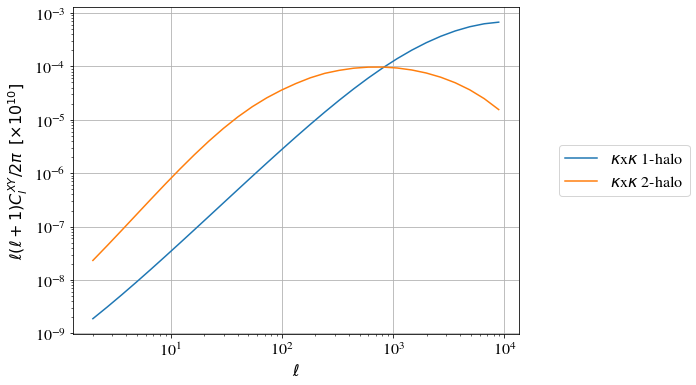

In [10]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.grid()
plt.plot(cl_kk['ell'],cl_kk['1h'],label=r'$\kappa$x$\kappa$ 1-halo')
plt.plot(cl_kk['ell'],cl_kk['2h'],label=r'$\kappa$x$\kappa$ 2-halo')

plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
plt.loglog()

# Computing gx$\kappa$

In [10]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'gal_lens_1h,gal_lens_2h',
        'mass function' : 'T10',
        'pressure profile': 'A10', 
        'galaxy_sample': 'unwise',
        'galaxy_sample_id': 'green',
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2
        })
        
M.compute()
cl_kg = M.cl_kg()
M.struct_cleanup()
M.empty()

[]

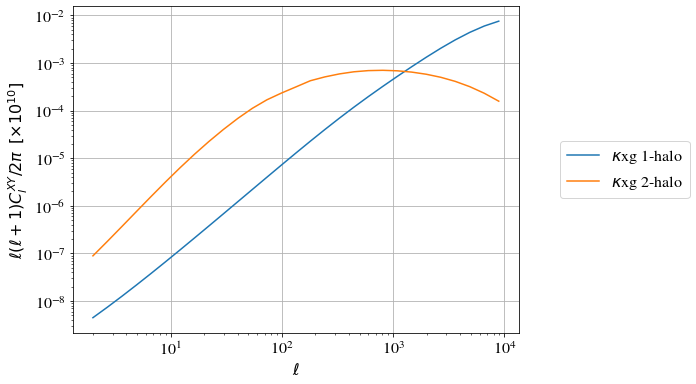

In [11]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.grid()
plt.plot(cl_kg['ell'],cl_kg['1h'],label=r'$\kappa$xg 1-halo')
plt.plot(cl_kg['ell'],cl_kg['2h'],label=r'$\kappa$xg 2-halo')

plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
plt.loglog()

# Computing gx$\kappa$ for different $x_\mathrm{out}$

[]

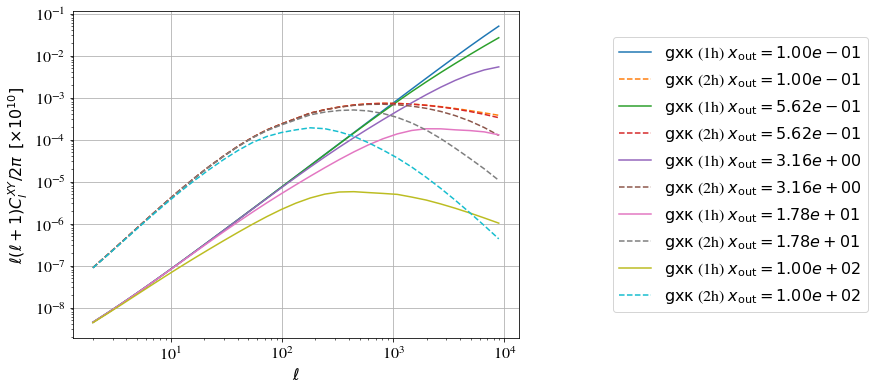

In [12]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.grid()


p_arr  = np.geomspace(1e-1,1e2,5)

for p in p_arr:

    M = Class()
    M.set(common_settings)
    M.set({# class_sz parameters:
            'output':'gal_lens_1h,gal_lens_2h',
            'mass function' : 'T10',
            'pressure profile': 'A10', 
            'galaxy_sample': 'unwise',
            'galaxy_sample_id': 'green',
            'sz_verbose' : 10,
            'ell_max_mock' : 10000,
            'ell_min_mock' : 2,   
            'x_out_truncated_nfw_profile': p
            })

    M.compute()
    cl = M.cl_kg()
    M.struct_cleanup()
    M.empty()
    plt.loglog(cl['ell'],np.asarray(cl['1h']),label=r'$\mathrm{gx\kappa}$ (1h) $x_\mathrm{out} = %.2e$'%p)
    plt.loglog(cl['ell'],np.asarray(cl['2h']),ls='--',label=r'$\mathrm{gx\kappa}$ (2h) $x_\mathrm{out} = %.2e$'%p)


plt.legend(loc='right',bbox_to_anchor=(1.8, 0.5))
plt.loglog()

# Computing gx$\kappa$ for different $\alpha_\mathrm{s}$

[]

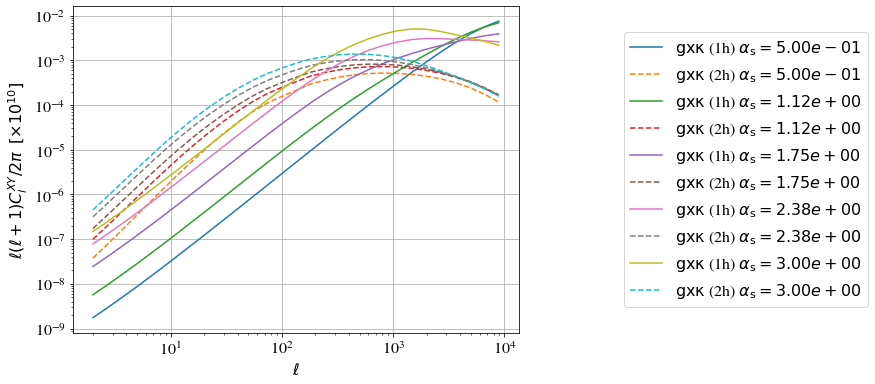

In [13]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.grid()


p_arr  = np.linspace(0.5,3,5)

for p in p_arr:

    M = Class()
    M.set(common_settings)
    M.set({# class_sz parameters:
            'output':'gal_lens_1h,gal_lens_2h',
            'mass function' : 'T10',
            'pressure profile': 'A10', 
            'galaxy_sample': 'unwise',
            'galaxy_sample_id': 'green',
            'sz_verbose' : 10,
            'ell_max_mock' : 10000,
            'ell_min_mock' : 2,   
            'alpha_s_HOD': p
            })

    M.compute()
    cl = M.cl_kg()
    M.struct_cleanup()
    M.empty()
    plt.loglog(cl['ell'],np.asarray(cl['1h']),label=r'$\mathrm{gx\kappa}$ (1h) $\alpha_\mathrm{s} = %.2e$'%p)
    plt.loglog(cl['ell'],np.asarray(cl['2h']),ls='--',label=r'$\mathrm{gx\kappa}$ (2h) $\alpha_\mathrm{s} = %.2e$'%p)


plt.legend(loc='right',bbox_to_anchor=(1.8, 0.5))
plt.loglog()

# Computing $\kappa$x$\mu$

In [14]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'lens_lensmag_1h,lens_lensmag_2h',
        'mass function' : 'T10',
        'galaxy_sample': 'unwise',
        'galaxy_sample_id': 'green',
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2
        })
        
M.compute()
cl_km = M.cl_km()
M.struct_cleanup()
M.empty()

[]

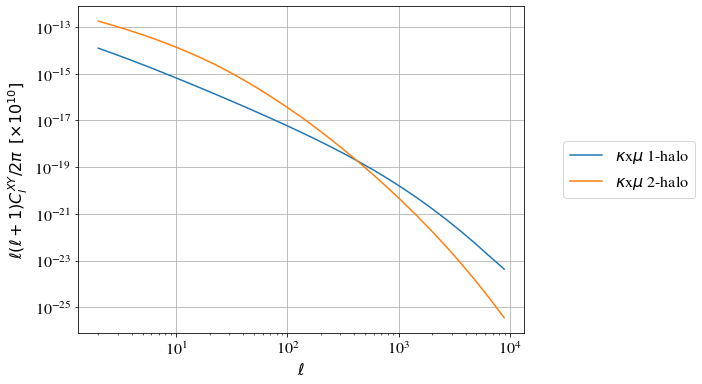

In [15]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.grid()
plt.plot(cl_km['ell'],cl_km['1h'],label=r'$\kappa$x$\mu$ 1-halo')
plt.plot(cl_km['ell'],cl_km['2h'],label=r'$\kappa$x$\mu$ 2-halo')

plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
plt.loglog()

# Computing gxg

In [16]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'gal_gal_1h,gal_gal_2h',
        'mass function' : 'T10',
        'galaxy_sample': 'unwise',
        'galaxy_sample_id': 'blue',
        'M_min_HOD_mass_factor_unwise': 0.8,
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2
        })
        
M.compute()
cl_gg = M.cl_gg()
M.struct_cleanup()
M.empty()

[]

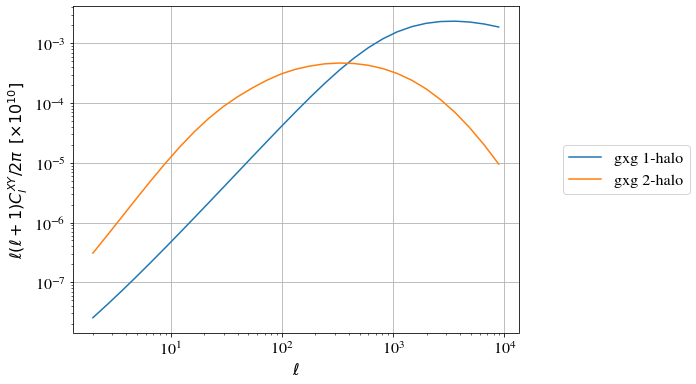

In [17]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.grid()
plt.plot(cl_gg['ell'],cl_gg['1h'],label='gxg 1-halo')
plt.plot(cl_gg['ell'],cl_gg['2h'],label='gxg 2-halo')

plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
plt.loglog()

# Computing $\mu$x$\mu$

In [18]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'lensmag_lensmag_1h,lensmag_lensmag_2h',
        'mass function' : 'T10',
        'galaxy_sample': 'unwise',
        'galaxy_sample_id': 'green',
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2
        })
        
M.compute()
cl_mm = M.cl_mm()
M.struct_cleanup()
M.empty()

[]

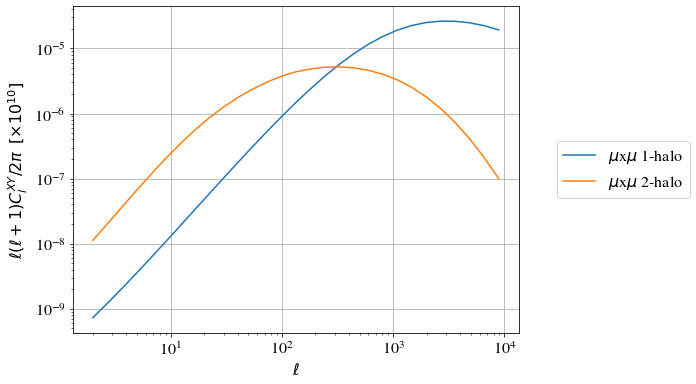

In [19]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.grid()
plt.plot(cl_mm['ell'],cl_mm['1h'],label='$\mu$x$\mu$ 1-halo')
plt.plot(cl_mm['ell'],cl_mm['2h'],label='$\mu$x$\mu$ 2-halo')

plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
plt.loglog()

# Computing yx$\mu$

(lensing magnification)

In [20]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'tSZ_lensmag_1h,tSZ_lensmag_2h',
        'mass function' : 'T10',
        'pressure profile': 'A10', 
        'galaxy_sample': 'unwise',
        'galaxy_sample_id': 'green',
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2,
        'M1SZ' : 1e8,
        'm_min_counter_terms' : 1e8
        })
        
M.compute()
cl_ym = M.cl_ym()
M.struct_cleanup()
M.empty()

[]

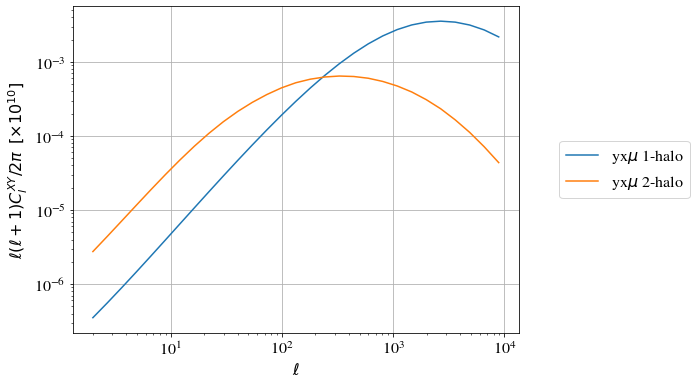

In [21]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.grid()
plt.plot(cl_ym['ell'],cl_ym['1h'],label=r'yx$\mu$ 1-halo')
# plt.plot(cl_ym['ell'],cl_ym['2h'],label=r'yx$\mu$ 2-halo')
plt.plot(cl_ym['ell'],np.asarray(cl_ym['2h']),label=r'yx$\mu$ 2-halo')


plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
plt.loglog()

# Computing yxg

In [22]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'tSZ_gal_1h,tSZ_gal_2h',
        'mass function' : 'T10',
        'pressure profile': 'A10', 
        'galaxy_sample': 'unwise',
        'galaxy_sample_id': 'green',
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2
        })
        
M.compute()
cl_yg = M.cl_yg()
M.struct_cleanup()
M.empty()

[]

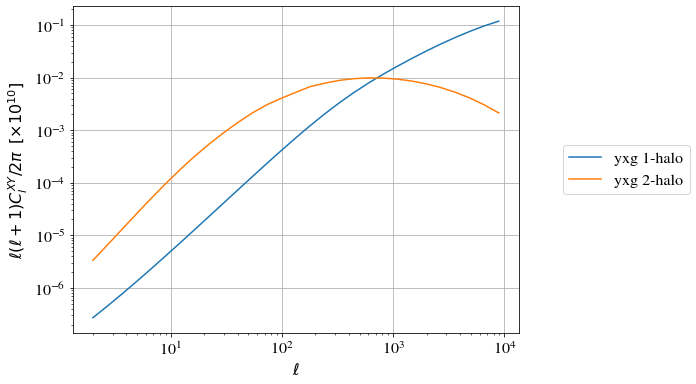

In [23]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.grid()
plt.plot(cl_yg['ell'],cl_yg['1h'],label='yxg 1-halo')
plt.plot(cl_yg['ell'],cl_yg['2h'],label='yxg 2-halo')

plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
plt.loglog()

# Computing yxy for different gNFW pressure profiles

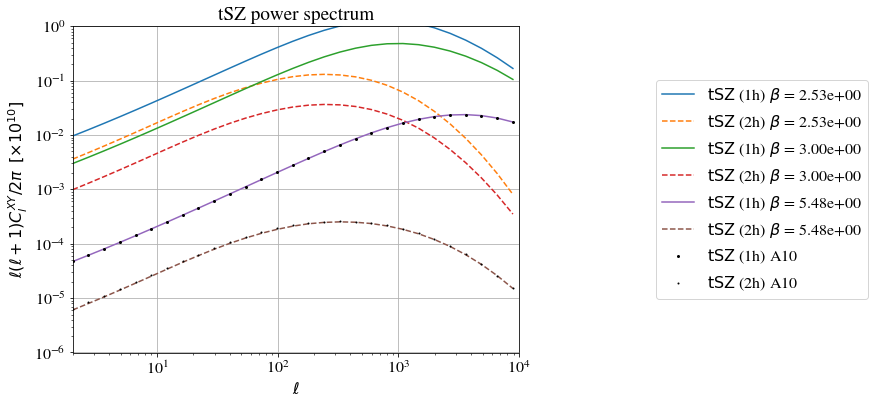

In [24]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'tSZ_1h,tSZ_2h',
        'mass function' : 'M500',
        'pressure profile': 'A10', 
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2
        })
        
M.compute()
cl_yy_a10 = M.cl_sz()
M.struct_cleanup()
M.empty()


plt.xlim([2,10000])
plt.ylim([1.e-6,1])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"tSZ power spectrum")
plt.grid()

p_arr  = np.linspace(2.53,3., 2)
p_arr = np.append(p_arr,5.4807)
for p in p_arr:

    M = Class()
    M.set(common_settings)
    M.set({# class_sz parameters:
           'output':'tSZ_1h,tSZ_2h',
           'mass function' : 'M500',
           'pressure profile': 'Custom. GNFW', 
           'betaGNFW': p,
           'sz_verbose' : 10,
           'ell_max_mock' : 10000,
           'ell_min_mock' : 2
            })

    M.compute()
    cl_sz = M.cl_sz()
    M.struct_cleanup()
    M.empty()
    plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['1h']),label=r'$\mathrm{tSZ}$ (1h) $\beta$ = %.2e'%p)
    plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['2h']),ls='--',label=r'$\mathrm{tSZ}$ (2h) $\beta$ = %.2e'%p)
    
plt.loglog(cl_yy_a10['ell'],factor_sz*np.asarray(cl_yy_a10['1h']),c='k',ls='None',marker='o',markersize=2,label=r'$\mathrm{tSZ}$ (1h) A10')
plt.loglog(cl_yy_a10['ell'],factor_sz*np.asarray(cl_yy_a10['2h']),c='k',ls='None',marker='o',markersize=1,label=r'$\mathrm{tSZ}$ (2h) A10')
plt.legend(loc='right',bbox_to_anchor=(1.8, 0.5))

# Computing yxg for different mass ranges

unwise HOD

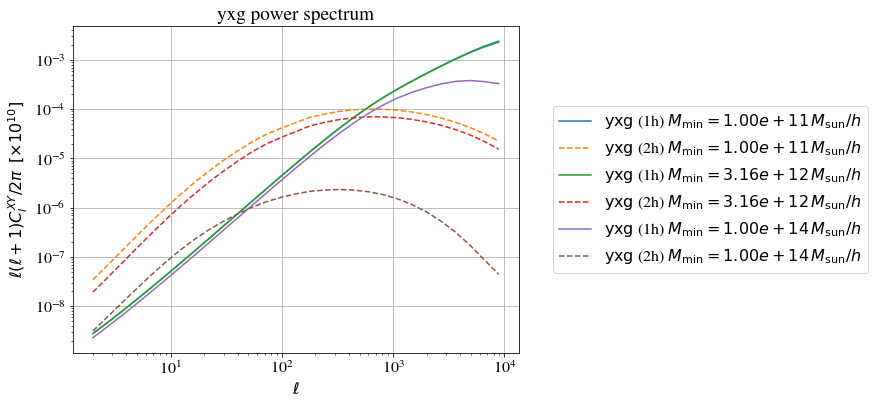

In [25]:

plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"yxg power spectrum")
plt.grid()

p_arr  = np.geomspace(1e11,1e14,3)

for p in p_arr:

    M = Class()
    M.set(common_settings)
    M.set({# class_sz parameters:
            'output':'tSZ_gal_1h,tSZ_gal_2h',
            'mass function' : 'M500',
            'pressure profile': 'A10', 
            'galaxy_sample': 'unwise',
            'galaxy_sample_id': 'green',
            'sz_verbose' : 10,
            'ell_max_mock' : 10000,
            'ell_min_mock' : 2,   
            'M1SZ': p
            })

    M.compute()
    cl_sz = M.cl_yg()
    M.struct_cleanup()
    M.empty()
    plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['1h']),label=r'$\mathrm{yxg}$ (1h) $M_\mathrm{min} = %.2e\,M_\mathrm{sun}/h$'%p)
    plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['2h']),ls='--',label=r'$\mathrm{yxg}$ (2h) $M_\mathrm{min} = %.2e\,M_\mathrm{sun}/h$'%p)
    
plt.legend(loc='right',bbox_to_anchor=(1.8, 0.5))

Additivity of mass range

In [26]:
m_min = 1e11
m_mid = 5e13
m_max = 1e17




M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'tSZ_gal_1h,tSZ_gal_2h',
        'mass function' : 'T10',
        'pressure profile': 'A10', 
        'galaxy_sample': 'unwise',
        'galaxy_sample_id': 'green',
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2,   
        'M1SZ': m_min,
        'M2SZ': m_max
    
        })

M.compute()
cl_sz_tot = M.cl_yg()
M.struct_cleanup()
M.empty()

M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'tSZ_gal_1h,tSZ_gal_2h',
        'mass function' : 'T10',
        'pressure profile': 'A10', 
        'galaxy_sample': 'unwise',
        'galaxy_sample_id': 'green',
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2,   
        'M1SZ': m_min,
        'M2SZ': m_mid
    
        })

M.compute()
cl_sz_low_m = M.cl_yg()
M.struct_cleanup()
M.empty()

M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'tSZ_gal_1h,tSZ_gal_2h',
        'mass function' : 'T10',
        'pressure profile': 'A10', 
        'galaxy_sample': 'unwise',
        'galaxy_sample_id': 'green',
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2,   
        'M1SZ': m_mid,
        'M2SZ': m_max
    
        })

M.compute()
cl_sz_high_m = M.cl_yg()
M.struct_cleanup()
M.empty()

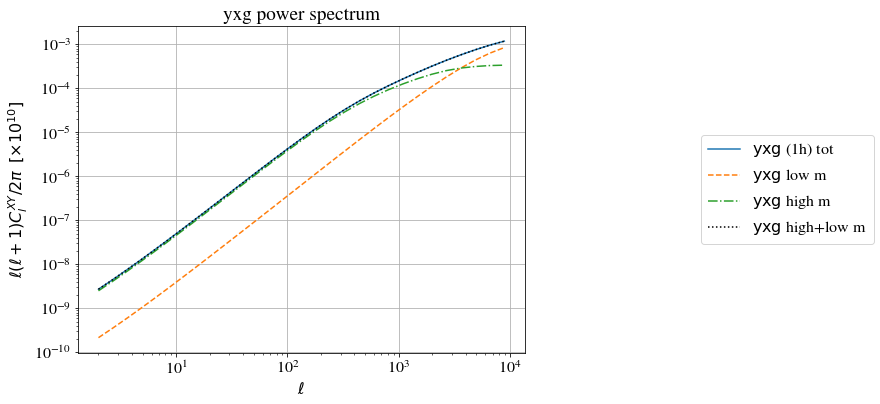

In [27]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"yxg power spectrum")
plt.grid()

plt.loglog(cl_sz_tot['ell'],factor_sz*np.asarray(cl_sz_tot['1h']),label=r'$\mathrm{yxg}$ (1h) tot')
plt.loglog(cl_sz_low_m['ell'],factor_sz*np.asarray(cl_sz_low_m['1h']),ls='--',label=r'$\mathrm{yxg}$ low m')
plt.loglog(cl_sz_high_m['ell'],factor_sz*np.asarray(cl_sz_high_m['1h']),ls='-.',label=r'$\mathrm{yxg}$ high m')
plt.loglog(cl_sz_tot['ell'],factor_sz*np.asarray(cl_sz_high_m['1h'])+factor_sz*np.asarray(cl_sz_low_m['1h']),ls=':',c='k',label=r'$\mathrm{yxg}$ high+low m')


    
plt.legend(loc='right',bbox_to_anchor=(1.8, 0.5))

2-halo term is not additive : 

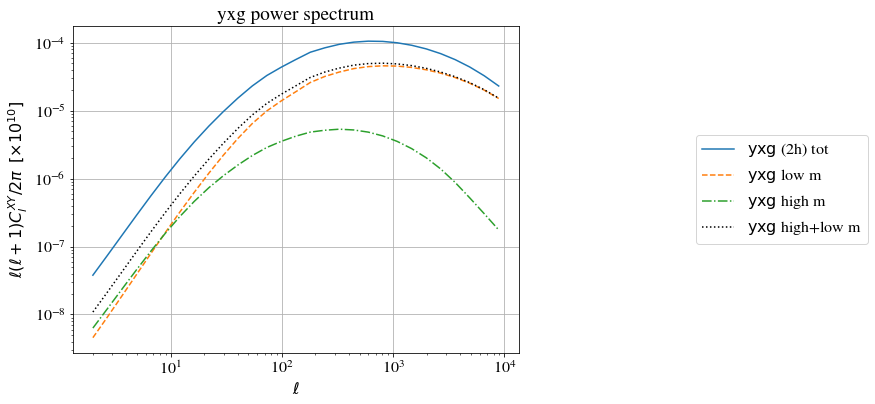

In [28]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"yxg power spectrum")
plt.grid()

plt.loglog(cl_sz_tot['ell'],factor_sz*np.asarray(cl_sz_tot['2h']),label=r'$\mathrm{yxg}$ (2h) tot')
plt.loglog(cl_sz_low_m['ell'],factor_sz*np.asarray(cl_sz_low_m['2h']),ls='--',label=r'$\mathrm{yxg}$ low m')
plt.loglog(cl_sz_high_m['ell'],factor_sz*np.asarray(cl_sz_high_m['2h']),ls='-.',label=r'$\mathrm{yxg}$ high m')
plt.loglog(cl_sz_tot['ell'],factor_sz*np.asarray(cl_sz_high_m['2h'])+factor_sz*np.asarray(cl_sz_low_m['2h']),ls=':',c='k',label=r'$\mathrm{yxg}$ high+low m')


    
plt.legend(loc='right',bbox_to_anchor=(1.8, 0.5))

WIxSC HOD

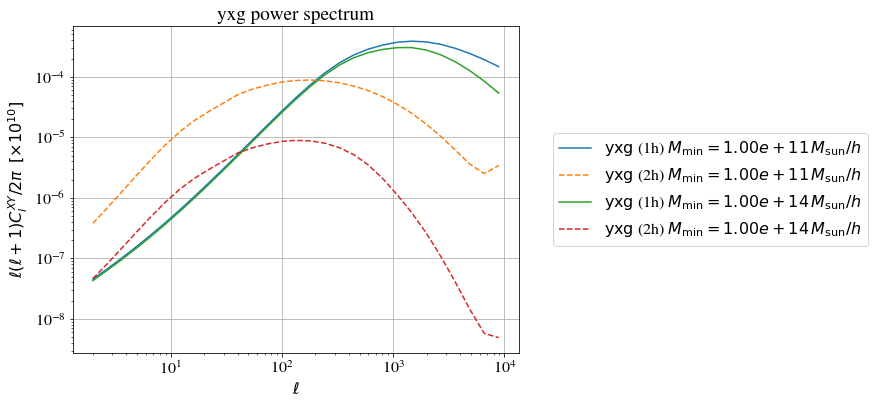

In [29]:

plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"yxg power spectrum")
plt.grid()

p_arr  = np.geomspace(1e11,1e14,2)
h = 0.7
for p in p_arr:

    M = Class()
    M.set(common_settings)
    M.set({# class_sz parameters:
            'output':'tSZ_gal_1h,tSZ_gal_2h',
            'mass function' : 'T10',
            'pressure profile': 'A10', 
            'galaxy_sample': 'WIxSC3',
            'sz_verbose' : 10,
            'ell_max_mock' : 10000,
            'ell_min_mock' : 2,   
            'M1SZ': p,
            'h': 0.7,
            'M_min_HOD' : 10.**11.32914985*h,
            'M1_prime_HOD' : 10.**12.51536196*h,
            'sigma_lnM_HOD' : 0.15
            })

    M.compute()
    cl_sz = M.cl_yg()
    M.struct_cleanup()
    M.empty()
    plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['1h']),label=r'$\mathrm{yxg}$ (1h) $M_\mathrm{min} = %.2e\,M_\mathrm{sun}/h$'%p)
    plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['2h']),ls='--',label=r'$\mathrm{yxg}$ (2h) $M_\mathrm{min} = %.2e\,M_\mathrm{sun}/h$'%p)
    
plt.legend(loc='right',bbox_to_anchor=(1.8, 0.5))

# Computing yxg for different gNFW pressure profiles

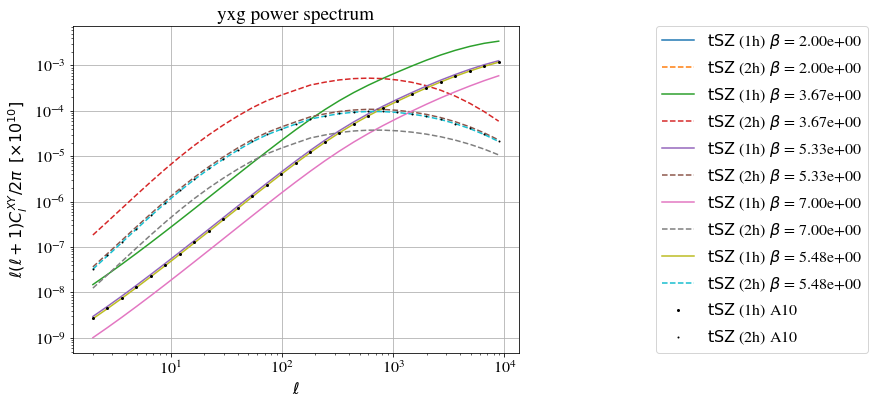

In [30]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'tSZ_gal_1h,tSZ_gal_2h',
        'mass function' : 'T10',
        'pressure profile': 'A10', 
        'galaxy_sample': 'unwise',
        'galaxy_sample_id': 'green',
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2
        })
        
M.compute()
cl_yg_a10 = M.cl_yg()
M.struct_cleanup()
M.empty()


plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"yxg power spectrum")
plt.grid()

p_arr  = np.linspace(2.,7., 4)
p_arr = np.append(p_arr,5.4807)
for p in p_arr:

    M = Class()
    M.set(common_settings)
    M.set({# class_sz parameters:
            'output':'tSZ_gal_1h,tSZ_gal_2h',
            'mass function' : 'T10',
            'pressure profile': 'Custom. GNFW', 
            'galaxy_sample': 'unwise',
            'galaxy_sample_id': 'green',
            'sz_verbose' : 10,
            'ell_max_mock' : 10000,
            'ell_min_mock' : 2,       
            'betaGNFW': p
            })

    M.compute()
    cl_sz = M.cl_yg()
    M.struct_cleanup()
    M.empty()
    plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['1h']),label=r'$\mathrm{tSZ}$ (1h) $\beta$ = %.2e'%p)
    plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['2h']),ls='--',label=r'$\mathrm{tSZ}$ (2h) $\beta$ = %.2e'%p)
    
plt.loglog(cl_yg_a10['ell'],factor_sz*np.asarray(cl_yg_a10['1h']),c='k',ls='None',marker='o',markersize=2,label=r'$\mathrm{tSZ}$ (1h) A10')
plt.loglog(cl_yg_a10['ell'],factor_sz*np.asarray(cl_yg_a10['2h']),c='k',ls='None',marker='o',markersize=1,label=r'$\mathrm{tSZ}$ (2h) A10')
plt.legend(loc='right',bbox_to_anchor=(1.8, 0.5))

# Computing gxg for different mass ranges

In [ ]:

plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"gxg power spectrum")
plt.grid()

p_arr  = np.geomspace(1e6,1e14,2)
h = 0.6766
for p in p_arr:

    M = Class()
    M.set(common_settings)
    M.set({# class_sz parameters:
            'output':'gal_gal_1h,gal_gal_2h',
            'mass function' : 'M500',
            'pressure profile': 'A10', 
            'galaxy_sample': 'WIxSC',
            'sz_verbose' : 10,
            'ell_max_mock' : 10000,
            'ell_min_mock' : 2,  
            'M1SZ': p,
            'h': h,
            'M_min_HOD' : 10.**11.32914985*h,
            'M1_prime_HOD' : 10.**12.51536196*h,
            'sigma_lnM_HOD' : 0.15,
            })

    M.compute()
    cl_sz = M.cl_gg()
    M.struct_cleanup()
    M.empty()
    plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['1h']),label=r'$\mathrm{gxg}$ (1h) $M_\mathrm{min} = %.2e\,M_\mathrm{sun}/h$'%p)
    plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['2h']),ls='--',label=r'$\mathrm{gxg}$ (2h) $M_\mathrm{min} = %.2e\,M_\mathrm{sun}/h$'%p)
    
plt.legend(loc='right',bbox_to_anchor=(1.8, 0.5))

# Obtaining the mass function

In [35]:
M = Class()
M.set(common_settings)
M.set({
    'output': 'dndlnM',
     'mass function' : 'T10'
})
M.compute()


In [36]:
z = 0.
m = 1e11
M.get_dndlnM_at_z_and_M(z,m)

0.030328472285823627

In [37]:
M.struct_cleanup()
M.empty()

# Obtaining $\sigma(M,z)$

In [38]:
M = Class()
M.set(common_settings)
M.set({
    'output': 'dndlnM',
})
M.compute()

In [39]:
z = 1.
m = 1e13
M.get_sigma_at_z_and_m(z,m)

0.9318613235552081

In [10]:
M.struct_cleanup()
M.empty()

# Obtaining $\nu(M,z)$
with $\nu = (\delta_\mathrm{crit}/\sigma)^2$ -- Note that in Tinker et al $\nu=\delta_\mathrm{crit}/\sigma$.

In [40]:
M = Class()
M.set(common_settings)
M.set({
    'output': 'dndlnM',
})
M.compute()

In [41]:
z = 1.
m = 1e13
M.get_nu_at_z_and_m(z,m)

3.2754435358511573

In [42]:
M.struct_cleanup()
M.empty()

# Obtaining linear bias $b$ and second order bias $b_2$


In [12]:
M = Class()
M.set(common_settings)
M.set({
    'output': 'dndlnM',
    'mass function' : 'T10'
})
M.compute()

In [13]:
z = 0.
nu = 2.
b1 = M.get_first_order_bias_at_z_and_nu(z,nu)
b2 = M.get_second_order_bias_at_z_and_nu(z,nu)
print('b1 = %.3f, b2 = %.3f'%(b1,b2))

b1 = 1.423, b2 = -0.577


In [18]:
nz = 10
nm = 100
z_arr = np.linspace(1e-5,3.,nz)
m_arr = np.geomspace(1e8,5e15,nm)
nu_arr = np.zeros((nz,nm))
b1_arr = np.zeros((nz,nm))
b2_arr = np.zeros((nz,nm))
for iz,z in enumerate(z_arr):
    for im,m in enumerate(m_arr):
        nu_arr[iz][im] = M.get_nu_at_z_and_m(z,m) 
        b1_arr[iz][im] = M.get_first_order_bias_at_z_and_nu(z,nu_arr[iz][im])
        b2_arr[iz][im] = M.get_second_order_bias_at_z_and_nu(z,nu_arr[iz][im])
        


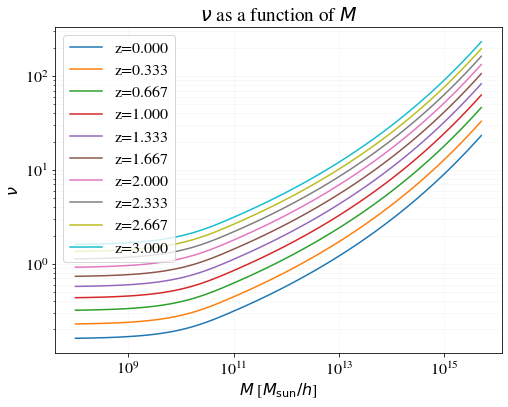

In [19]:
for iz,z in enumerate(z_arr):
    plt.plot(m_arr,nu_arr[iz],label='z=%.3f'%z)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=2)
plt.title(r'$\nu$ as a function of $M$')
plt.ylabel(r'$\nu$')
plt.xlabel(r'$M$ [$M_\mathrm{sun}/h$]')
plt.grid(which='both',alpha=0.1)


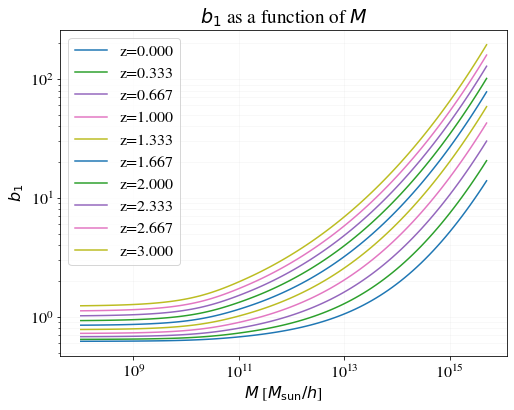

In [20]:
for iz,z in enumerate(z_arr):
    plt.plot(m_arr,b1_arr[iz],label='z=%.3f'%z)
    plt.plot(m_arr,-b1_arr[iz],ls='--')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=2)
plt.title(r'$b_1$ as a function of $M$')
plt.ylabel(r'$b_1$')
plt.xlabel(r'$M$ [$M_\mathrm{sun}/h$]')
plt.grid(which='both',alpha=0.1)

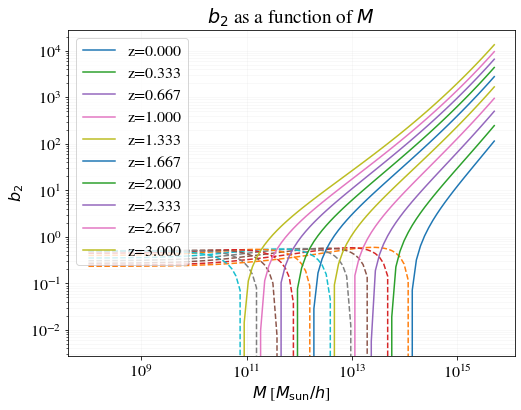

In [21]:
for iz,z in enumerate(z_arr):
    plt.plot(m_arr,b2_arr[iz],label='z=%.3f'%z)
    plt.plot(m_arr,-b2_arr[iz],ls='--')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=2)
plt.title(r'$b_2$ as a function of $M$')
plt.ylabel(r'$b_2$')
plt.xlabel(r'$M$ [$M_\mathrm{sun}/h$]')
plt.grid(which='both',alpha=0.1)

# Obtaining counter terms for halo model consistency


In [42]:
M = Class()
M.set(common_settings)
M.set({
    'output': 'dndlnM',
    'mass function' : 'T10',
    'hm_consistency': 1,
    'M1SZ': 1e9,
    'm_min_counter_terms' : 1e9,
})
M.compute()

In [43]:
m_min = M.M1SZ()
print('minimal mass : %.3e'%m_min)
# n_at_m_min = 

minimal mass : 1.000e+09


In [44]:

m = m_min
n_min_over_hmf_min  = []
b1_min_over_b1_of_min  = []
b2_min_over_b2_of_min  = []
z_arr = np.linspace(1.e-5,4,100)

for z in z_arr:
    n_min_over_hmf_min.append(M.get_hmf_counter_term_nmin_at_z(z)/M.get_dndlnM_at_z_and_M(z,m))
    numin = M.get_nu_at_z_and_m(z,m) 
    b1_of_min = M.get_first_order_bias_at_z_and_nu(z,numin)
    b2_of_min = M.get_second_order_bias_at_z_and_nu(z,numin)
    b1_min_over_b1_of_min.append(M.get_hmf_counter_term_b1min_at_z(z)/b1_of_min)
    b2_min_over_b2_of_min.append(M.get_hmf_counter_term_b2min_at_z(z)/b2_of_min)
n_min_over_hmf_min = np.asarray(n_min_over_hmf_min)
b1_min_over_b1_of_min = np.asarray(b1_min_over_b1_of_min)
b2_min_over_b2_of_min = np.asarray(b2_min_over_b2_of_min)

In [45]:
M.struct_cleanup()
M.empty()

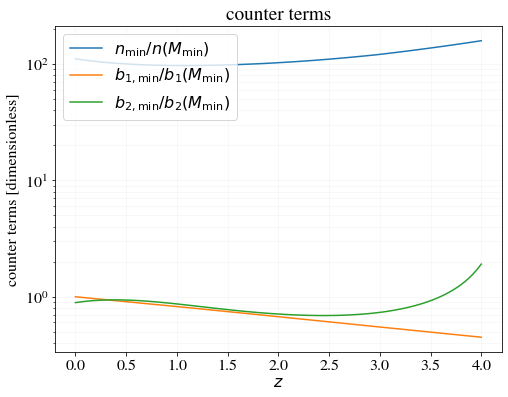

In [46]:
plt.plot(z_arr,n_min_over_hmf_min,label=r'$n_\mathrm{min}/n(M_\mathrm{min})$')
plt.plot(z_arr,b1_min_over_b1_of_min,label=r'$b_\mathrm{1,min}/b_1(M_\mathrm{min})$')
plt.plot(z_arr,b2_min_over_b2_of_min,label=r'$b_\mathrm{2,min}/b_2(M_\mathrm{min})$')
plt.xscale('linear')
plt.yscale('log')
plt.legend(loc=2)
plt.title('counter terms')
plt.ylabel(r'counter terms [dimensionless]')
plt.xlabel(r'$z$')
plt.grid(which='both',alpha=0.1)
plt.savefig('counter_terms_boris_Mmin_1e11.pdf')

# testing different HM consistency conditions

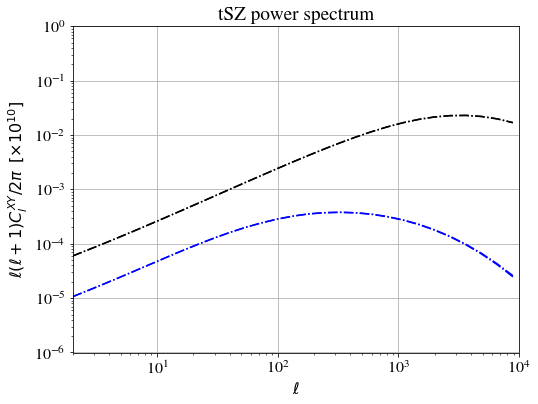

In [17]:
plt.xlim([2,10000])
plt.ylim([1.e-6,1])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"tSZ power spectrum")
plt.grid()

p_arr  = [0,1,2]
for p in p_arr:

    M = Class()
    M.set(common_settings)
    M.set({# class_sz parameters:
           'output':'tSZ_1h,tSZ_2h',
           #'pressure profile': 'A10', 
           #'sz_verbose' : 10,
           'mass function' : 'T10',
           'hm_consistency': p,
           'M1SZ': 1e11,
           'ell_max_mock' : 10000,
           'ell_min_mock' : 2
            })

    M.compute()
    cl_sz = M.cl_sz()
    M.struct_cleanup()
    M.empty()
    plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['1h']),'k-.',label=r'$\mathrm{tSZ}$ (1h)')
    plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['2h']),'b-.',label=r'$\mathrm{tSZ}$ (2h)')

[]

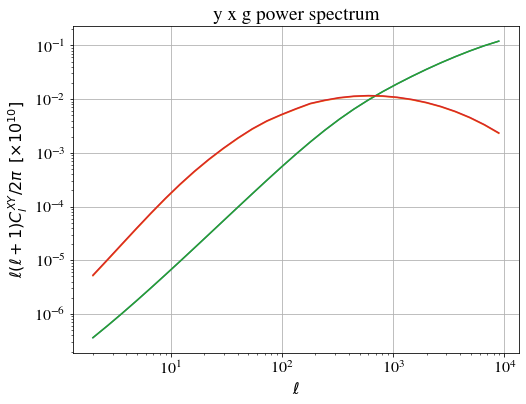

In [20]:
# plt.xlim([2,10000])
# plt.ylim([1.e-6,1])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"y x g power spectrum")
plt.grid()

p_arr  = [0,1,2]
for p in p_arr:
    M = Class()
    M.set(common_settings)
    M.set({# class_sz parameters:
            'output':'tSZ_gal_1h,tSZ_gal_2h',
            'mass function' : 'T10',
            'pressure profile': 'A10', 
            'galaxy_sample': 'unwise',
            'galaxy_sample_id': 'green',
            'sz_verbose' : 10,
            'ell_max_mock' : 10000,
            'ell_min_mock' : 2,
            'hm_consistency': p,
            'M1SZ': 1e11
            })

    M.compute()
    cl_yg = M.cl_yg()
    M.struct_cleanup()
    M.empty()
    plt.plot(cl_yg['ell'],cl_yg['1h'],label='yxg 1-halo')
    plt.plot(cl_yg['ell'],cl_yg['2h'],label='yxg 2-halo')

plt.loglog()
